# Tarea 16 de Octubre

In [35]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'y')

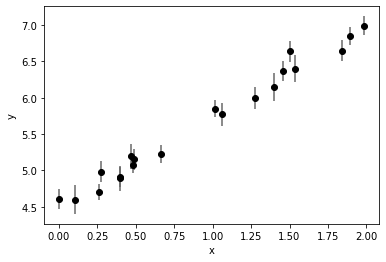

In [36]:
n = 20 # number of data points
m = 1.255 # randomly chosen truth
b = 4.507 

x = np.random.uniform(0, 2., n)
x.sort() # sort the values in place

# evaluate the true model at the given x values
y = m*x + b

# Heteroscedastic Gaussian uncertainties only in y direction
y_err = np.random.uniform(0.1, 0.2, size=n) # randomly generate uncertainty for each datum
y = np.random.normal(y, y_err) # re-sample y data with noise

datastyle = dict(linestyle='none', marker='o', color='k', ecolor='#666666')
plt.errorbar(x, y, y_err,**datastyle)
plt.xlabel('x')
plt.ylabel('y')

In [98]:
#Definimos una función que evalue un modelo de linea recta en los valores x
# la variabele pars contiene los valores de los parametros m, b de la recta
def LineaRecta(pars, x):
    return pars[0]*np.array(x) + pars[1]

In [99]:


class ModeloLineaRecta(object):
    
    def __init__(self, x, y, y_err):
        """ 
        We store the data as attributes of the object so we don't have to 
        keep passing it in to the methods that compute the probabilities.
        """
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.y_err = np.asarray(y_err)

    def ln_likelihood(self, pars):
        """
        We don't need to pass in the data because we can access it from the
        attributes. This is basically the same as the weighted squared 
        deviation function, but includes the constant normalizations for the
        Gaussian likelihood.
        """
        N = len(self.y)
        dy = self.y - LineaRecta(pars, self.x)
        ivar = 1 / self.y_err**2 # inverse-variance
        return -0.5 * (N*np.log(2*np.pi) + np.sum(2*np.log(self.y_err)) + np.sum(dy**2 * ivar))

    def ln_prior(self, pars):
        """ 
        The prior only depends on the parameters, so we don't need to touch
        the data at all. We're going to implement a flat (uniform) prior 
        over the ranges:
            a : [0, 100]
            b : [-50, 50]
        
        """
        
        m, b = pars # unpack parameters
        ln_prior_val = 0. # we'll add to this

        if m < 0 or m > 100.:
            return -np.inf
        else:
            ln_prior_val += np.log(1E-2) # normalization, log(1/100)

        if m < -50 or m > 50.:
            return -np.inf
        else:
            ln_prior_val += np.log(1E-2) # normalization, log(1/100)

        return ln_prior_val

    def ln_posterior(self, pars):
        """ 
        Up to a normalization constant, the log of the posterior pdf is just 
        the sum of the log likelihood plus the log prior.
        """
        lnp = self.ln_prior(pars)
        if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
            return lnp

        lnL = self.ln_likelihood(pars)
        lnprob = lnp + lnL

        if np.isnan(lnprob):
            return -np.inf

        return lnprob
    
    def __call__(self, pars):
        return self.ln_posterior(pars)

modelo = ModeloLineaRecta(x, y, y_err)



In [96]:
def sample_proposal(*sigmas):
    return np.random.normal(0., sigmas)

def MCMC(p_init, N_iter, modelo, proposal_sigmas):
    """
    Run a Metropolis-Hastings MCMC sampler to generate samples from the input
    log-posterior function, starting from some initial parameter vector.
    
    Parameters
    ----------
    p0 : iterable
        Initial parameter vector.
    n_steps : int
        Number of steps to run the sampler for.
    model : StraightLineModel instance (or subclass)
        A callable object that takes a parameter vector and computes 
        the log of the posterior pdf.
    proposal_sigmas : list, array
        A list of standard-deviations passed to the sample_proposal 
        function. These are like step sizes in each of the parameters.
    """
    p_init = np.array(p_init)
    if len(proposal_sigmas) != len(p_init):
        raise ValueError("Proposal distribution should have same shape as parameter vector.")
    
    # the objects we'll fill and return:
    chain = np.zeros((N_iter, len(p_init))) # parameter values at each step
    ln_probs = np.zeros(N_iter) # log-probability values at each step
    
    # we'll keep track of how many steps we accept to compute the acceptance fraction                        
    n_accept = 0 
    
    # evaluate the log-posterior at the initial position and store starting position in chain
    ln_probs[0] = modelo(p_init)
    chain[0] = p_init
    
    # loop through the number of steps requested and run MCMC
    for i in range(1,N_iter):
        # proposed new parameters
        step = sample_proposal(*proposal_sigmas)
        new_p = chain[i-1] + step
        
        # compute log-posterior at new parameter values
        new_ln_prob = modelo(new_p)
        
        # log of the ratio of the new log-posterior to the previous log-posterior value
        ln_prob_ratio = new_ln_prob - ln_probs[i-1]
        
        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform())):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1
            
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
    
    acc_frac = n_accept / N_iter
    return chain, ln_probs, acc_frac

In [100]:
p_init = [6.,6.]
chain,_,acc_frac = MCMC(p_init, N_iter=10000, modelo=modelo, proposal_sigmas=[0.05,0.05])
print("Acceptance fraction: {:.1%}".format(acc_frac))

Acceptance fraction: 40.5%


Text(0, 0.5, '$b$')

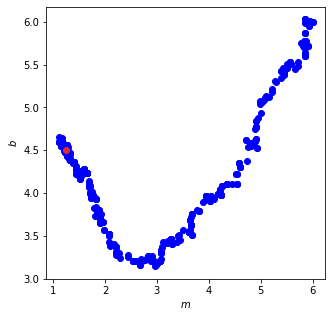

In [104]:
fig,ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(m, b, marker='o', zorder=10, color='#de2d26')
#ax.plot(chain[:512,0], chain[:512,1], marker='', color='k', linewidth=1.)

plt.scatter(chain[:512,0], chain[:512,1], c='b')
ax.set_xlabel('$m$')
ax.set_ylabel('$b$')